# Thông tin nhóm 14

1612406 - Đặng Phương Nam

1612423 - Lê Minh nghĩa

# 1. Câu hỏi

Cho các thông tin về căn nhà:

- Giá cho thuê trước khi bán.
- Địa chỉ.
- Loại nhà.
- Số phòng ngủ.
- Số nhà vệ sinh.
- Diện tích phần nhà.
- Diện tích toàn bộ lô đất.
- Năm xây dựng.
- Tiền thuế.
- Gần mấy trường học.
- Tình hình tội phạm.
- ...

Hỏi giá trị của căn nhà là bao nhiêu tiền?

# 2. Lợi ích khi trả lời được câu hỏi

Nhờ vào thông tin của căn nhà:

- Người bán có thể dự đoán được giá trị căn nhà mà mình muốn bán.
- Người mua có thể ước lượng được căn nhà mình muốn mua có giá cả hợp lý hay không?.
- Dự đoán được giá trị căn nhà của mình.
- ...

# 3. Thu thập dữ liệu

## 3.1. Parse HTML

Dữ liệu thu thập từ trang web https://www.realtytrac.com/. Ta chỉ thu thập dữ liệu "các estate đã được bán tại  California", ta có HTML cần parse: https://m.realtytrac.com/mapsearch/sold/ca/

Thời gian lấy dữ liệu: Ngày 10/12/2019

In [ ]:
# Import các thư viện cần thiết.
import urllib.robotparser
import json
import os.path
import re

from requests_html import HTMLSession

In [ ]:
rp = urllib.robotparser.RobotFileParser()
rp.set_url('https://m.realtytrac.com/robots.txt')
rp.read()

In [ ]:
# Lấy link chứa danh sách các ngôi nhà đã bán theo Quận tại California
check_parse = rp.can_fetch('*', 'https://m.realtytrac.com/mapsearch/sold/ca/')

base_url = "https://m.realtytrac.com"
list_url_county = []

# Kiểm tra việc parse HTML được cho phép hay không?
if check_parse == True:
    session = HTMLSession()
    r = session.get('https://m.realtytrac.com/mapsearch/sold/ca/')

    counties = r.html.find("option")

    for county in counties:
        tail_url = county.attrs['value']
        if (tail_url):
            url = base_url + tail_url
            list_url_county.append(url)


list_url_county

In [ ]:
# Hàm trả về generator, generator này trả về trang tiếp theo sau mỗi lần duyệt.
def urlGenerator(baseUrl, startPage=1):
    i = startPage
    if i <= 1:
        yield baseUrl
        i = 2
    while True:
        yield f"{baseUrl}/p-{i}"
        i += 1


# Hàm parseDetailPage: parse để lấy thông tin chi tiết của từng căn nhà từ detailUrl (của căn nhà đã bán).
# Tham số: session và detailUrl của căn nhà cần parse.
# Trả về: dictionary chứa các thông tin đã parse được.
def parseDetailPage(session: HTMLSession, detailUrl: str):

    # Lấy mã HTML của trang web.
    r = session.get(detailUrl)

    # Dictionary lưu lại kết quả.
    result = {}

    # Lấy address của estate.
    address = {}
    street = r.html.find("[itemprop = 'streetAddress']", first=True)
    if street is not None:
        street = street.text

    locality = r.html.find("[itemprop = 'addressLocality']", first=True)
    if locality is not None:
        locality = locality.text

    region = r.html.find("[itemprop = 'addressRegion']", first=True)
    if region is not None:
        region = region.text

    code = r.html.find("[itemprop = 'postalCode']", first=True)
    if code is not None:
        code = code.text

    address["street"] = street
    address["locality"] = locality
    address["region"] = region
    address["code"] = code

    result["address"] = address

    # Lấy thông tin ngày đã bán căn nhà.
    date_sold = r.html.find(".recently-sold", first=True)
    if date_sold is not None:
        result["date_sold"] = date_sold.text.replace("SOLD ON ", "")
    else:
        result["date_sold"] = None

    # Lấy giá cho thuê trước khi bán.
    mortgage = r.html.find(".property-price-info", first=True)
    if mortgage is not None:
        result["mortgage"] = mortgage.text.replace("Est. Mortgage: ","")
    else:
        result["mortgage"] = None


    # Lấy phân mô tả chi tiết về căn nhà.
    details = []
    detailTexts = r.html.find(".detail-text")
    if detailTexts is not None:
        for detailText in detailTexts:
            details.append(detailText.html)  # sở dĩ lấy mà HTML để dễ parse sau này (khi muốn lấy thông tin từ details)
    result["details"] = details

    # Lấy property info của căn nhà.
    propertyInfo = r.html.find(".property-info", first=True)
    if propertyInfo is not None:
        info = {}
        items = propertyInfo.find(".item")
        if items is not None:
            for item in items:
                name = item.find(".name", first=True).text.lower().replace(" ", "_")
                value = item.find(".value", first=True).text
                info[name] = value

        result["info"] = info
    else:
        result["info"] = None

    # Lấy property taxes của căn nhà.
    property_taxes = r.html.find(".property-taxes")
    if property_taxes is not None:
        for tax in property_taxes:
            key = tax.find(".section-head", first=True).text.lower().replace(" ", "_")
            taxes = {}
            items = tax.find(".item")
            if items is not None:
                for item in items:
                    name = item.find(".name", first=True).text.lower().replace(" ", "_")
                    value = item.find(".value", first=True).text
                    taxes[name] = value

            result[key] = taxes

    # Lấy số lượng trường học gần đó.
    local_school = r.html.find(".property-schools", first=True)
    num_school = 0
    if local_school is not None:
        num_school = len(local_school.find(".schoolInfo"))

    result["school"] = num_school

    # Lấy thông tin tội phạm trong vùng.
    crimes = {}
    local_crime_index = r.html.find(".property-local-crime", first=True)
    if local_crime_index is not None:
        type_crimes = local_crime_index.find(".gradeTitle")
        if type_crimes is not None:
            for type_crime in type_crimes:
                match = re.match(r"(.+?) = (\d+)", type_crime.text)
                if match is not None:
                    key = match.group(1).lower().replace(' ', '_')
                    value = int(match.group(2))
                    crimes[key] = value

    result["local_crime_index"] = crimes

    # Lấy số lượng nhà bị tịch thu gần đó.
    nearby_foreclosures = r.html.find(".property-nearby-fc", first=True)
    num_fc = 0
    if nearby_foreclosures is not None:
        num_fc = len(nearby_foreclosures.find(".nearby-property"))

    result["foreclosures"] = num_fc

    return result

In [ ]:
# Hàm parseSearchPage: parse theo page (mỗi parse chứa danh sách và url của 25 căn nhà đã được bán).
# Tham số: session và url của page hiện tại.
# Trả về: list thông tin chi tiết của tất cả căn nhà tại page hiện tại và url của page kế tiếp.
def parseSearchPage(session: HTMLSession, urlPage: str):

    # Lấy mã HTML.
    r = session.get(urlPage)

    # Lấu detailUrl của tất cả bất động sản.
    detailUrls = [link for link in r.html.absolute_links if 'property' in link]

    results = []  # List chứa kết quả parse được tại page.

    # Tiến hành parse từ detailUrl
    for detailUrl in detailUrls:
        # Kiểm tra việc parse HTML được cho phép hay không?
        if not rp.can_fetch('*', detailUrl):
            print(f"SKIP: {detailUrl}")
            continue

        print(f"Parsing detail url {detailUrl}")
        result = parseDetailPage(session, detailUrl)
        results.append(result)

    nextPageAnchor = r.html.find(".current + .page", first=True)
    return results, nextPageAnchor is not None

In [ ]:
# Hàm getAllCountyProperties: parse tất cả các page của một County để lấy thông tin chi tiết của 
# căn nhà được bán thành công.
# Tham số: session và countryUrl chứa thông tin các căn nhà được bán của một County.
# Trả về: File chứa kết quả đã parse thành công (tên file là tên County được parse).
def getAllCountyProperties(session: HTMLSession, countyUrl: str):
    # Lấy tên County từ urlCounty.
    if countyUrl.endswith("/"):
        countyUrl = countyUrl[:-1]
    fileName = f"data/{os.path.basename(countyUrl)}.json"

    # Kiểm tra sự tồn tại file.
    if os.path.exists(fileName):
        print(f"FILE EXISTS: {fileName}")
        return

    # Mở file để ghi dữ liệu (kiểu file là json)
    with open(fileName, "a") as fOut:
        for url in urlGenerator(countyUrl, 1):
            # Kiểm tra việc parse HTML được cho phép hay không?
            if not rp.can_fetch('*', url):
                print(f"SKIP: {url}")
                continue

            # Tiến hành parse theo từng page.
            print(f"Parsing {url}")
            results, nextPage = parseSearchPage(session, url)

            # Ghi kết quả xuống file.
            for result in results:
                json.dump(result, fOut, ensure_ascii=False)
                fOut.write("\n")

            # Kiểm tra có còn page tiếp theo hay không?
            if not nextPage:
                break

            # Mỗi lần parse 1 page thì cho sleep 2s.
            time.sleep(2)

Tiến hành lấy dữ liệu. Lưu ý trong quá trình lấy có thể bị timeout do đường truyền mạng, nếu bị thì chỉ cần làm theo các bước sau:
- Xem đã lấy tới page mấy. vd: "...page-125"
- Đổi lại tên file trong thư mục data là "orange-county-1.json" chẳng hạn (số 1, 2, 3,.. là theo mỗi lần lấy dữ liệu của mình).
- Vào hàm "getAllCountyProperties" đổi lại dòng "for url in urlGenerator(countyUrl, 1)" thành "for url in urlGenerator(countyUrl, 125)", số 125 là tùy mình lấy tới page thứ mấy mà bị timeout.
- Dữ liệu tất nhiên sẽ bi trùng, cứ việc yên tâm vì phần sau sẽ xóa trung.

In [ ]:
url = "https://m.realtytrac.com/mapsearch/sold/ca/orange-county"
session = HTMLSession()
getAllCountyProperties(session, url)

In [ ]:
# Phần gộp từng phần dữ liệu đã lấy dang dở lại thành 1 file.
# Nếu không bị timeout như trường hợp ở trên thì không dùng shell code này.
inputFiles = ["data/orange-county-1.json", "data/orange-county-2.json", 
              "data/orange-county-3.json", "data/orange-county-4.json"]
outputFile = "data/full-orange-county.json"

with open(outputFile, "a+") as fOut:
    for inputFile in inputFiles:
        with open(inputFile, "r") as fIn:
            data = fIn.read()
            fOut.write(data)

In [ ]:
# Phần convert file json sang file csv.

def xstr(s):
    return '' if s is None else str(s)


# Hàm preprocessFile: chuyển file json sang file csv.
# Tham số: tên file json và tên file csv.
# Không trả về.
def preprocessFile(inputFile: str, outputFile: str):

    # Kiểm tra tồn tại file Input.
    if os.path.exists(outputFile):
        print(f"FILE EXISTS: {outputFile}")
        return

    # Kiểm tra tồn tại file Output.
    if not os.path.exists(inputFile):
        print(f"Input file not found: {inputFile}")
        return

    with open(inputFile) as fIn, open(outputFile, "w") as fOut:
        tab = "\t"
        headers = (
            "address_street",
            "address_locality",
            "address_region",
            "address_code",
            "date_sold",
            "mortgage",
            "info_type",
            "info_bedrooms",
            "info_bathrooms",
            "info_size",
            "info_lot_size",
            "info_year_built",
            "info_est_value",
            "info_sold_price",
            "info_property_id",
            "info_county",
            "info_parcel_number",
            "taxes_land",
            "taxes_improvements",
            "taxes_total",
            "taxes_taxes",
            "school",
            "total_crime",
            "violent_crime",
            "property_crime",
            "foreclosures",
        )

        # Ghi các tên cột vào file output, mỗi cột ngăn cách bởi "\t".
        fOut.write(f"{tab.join(headers)}\n")

        # Duyệt từng line trong file Input (json).
        for line in fIn:
            row = json.loads(line)

            # Lấy địa chỉ
            address = row.get("address")
            address_street = address.get("street")
            address_locality = address.get("locality")
            address_region = address.get("region")
            address_code = address.get("code")

            # Lấy ngày bán thành công.
            date_sold = row.get("date_sold")

            # Lấy giá cho thuê mỗi tháng (trước khi được bán).
            mortgage = row.get("mortgage")
            if mortgage is not None:
                mortgage = float(mortgage.replace("$","").replace(",","").replace("/mo","").replace("Est. Refinance: ", ""))

            # Lấy phần info
            info = row.get("info")

            # Type.
            info_type = info.get("type")

            # Bedrooms.
            info_bedrooms = info.get("bedrooms")
            if info_bedrooms == "Contact Agent":
                info_bedrooms = None
            else:
                info_bedrooms = float(info_bedrooms)

            # Bathrooms.
            info_bathrooms = info.get("bathrooms")
            if info_bathrooms == "Contact Agent":
                info_bathrooms = None
            else:
                info_bathrooms = float(info_bathrooms)

            # Size.
            info_size = info.get("size")
            if info_size == "Contact Agent":
                info_size = None
            else:
                info_size = float(info_size.replace(",", "").replace(" sqft", ""))

            # Lot size.
            info_lot_size = info.get("lot_size")
            if info_lot_size == "Contact Agent":
                info_lot_size = None
            else:
                info_lot_size = float(info_lot_size.replace(",", "").replace(" sqft", "").replace(" acres", ""))

            # Year build.
            info_year_built = info.get("year_built")
            if info_year_built  == "Contact Agent":
                info_year_built = None
            else:
                info_year_built = int(info_year_built)

            # Est value.
            info_est_value = info.get("est._value")
            if info_est_value is not None:
                info_est_value = float(info_est_value.replace("$", "").replace(",",""))

            # Sold price.
            info_sold_price = info.get("sold_price")
            if info_sold_price is not None:
                if info_sold_price != "N/A":
                    info_sold_price = float(info_sold_price.replace("$", "").replace(",", ""))

            # ID.
            info_property_id = info.get("property_id")

            # County.
            info_county = info.get("county")

            # Parcel_number.
            info_parcel_number = info.get("parcel_number")

            # Lấy phần Taxes.
            taxes = row.get("property_taxes")
            taxes_land = None
            taxes_improvements = None
            taxes_total = None
            taxes_taxes = None
            if taxes is not None:
                taxes_land = float(taxes.get("land").replace("$", "").replace(",", ""))
                taxes_improvements = float(taxes.get("improvements").replace("$", "").replace(",", ""))
                taxes_total = float(taxes.get("total").replace("$", "").replace(",", ""))
                taxes_taxes = taxes.get("taxes").replace("$", "").replace(",", "")

            # Lấy số lượng scholl gần đó.
            school = int(row.get("school"))

            # Lấy tình hình tội phạm.
            crime = row.get("local_crime_index")
            if crime is not None:
                total_crime = crime.get("total_crime")
                if total_crime is not None:
                    total_crime = int(total_crime)
                violent_crime = crime.get("violent_crime")
                if violent_crime is not None:
                    violent_crime = int(violent_crime)
                property_crime = crime.get("property_crime")
                if property_crime is not None:
                    property_crime = int(property_crime)

            # Lấy số lượng foreclosures gần đó.
            foreclosures = int(row.get("foreclosures"))

            # Row này là tổng hợp các thông tin lấy được ở trên.
            row = (
                xstr(address_street),
                xstr(address_locality),
                xstr(address_region),
                xstr(address_code),
                xstr(date_sold),
                xstr(mortgage),
                xstr(info_type),
                xstr(info_bedrooms),
                xstr(info_bathrooms),
                xstr(info_size),
                xstr(info_lot_size),
                xstr(info_year_built),
                xstr(info_est_value),
                xstr(info_sold_price),
                xstr(info_property_id),
                xstr(info_county),
                xstr(info_parcel_number),
                xstr(taxes_land),
                xstr(taxes_improvements),
                xstr(taxes_total),
                xstr(taxes_taxes),
                xstr(school),
                xstr(total_crime),
                xstr(violent_crime),
                xstr(property_crime),
                xstr(foreclosures),
            )

            # Ghi xuống file output
            fOut.write(f"{tab.join(row)}\n")

In [ ]:
inputFile = "data/full-orange-county.json"
outputFile = "data/orange-county.csv"
preprocessFile(inputFile, outputFile)

## 3.2. Lựa chọn dữ liệu của năm 2019 có "correct ouput"

In [ ]:
# Import các thư viện cần thiết.
import pandas as pd

### 3.2.1 Xóa dữ liệu trùng

#### Dữ liệu ban đầu

In [ ]:
file_csv = "data/Orange-County/orange-county.csv"
data_df =  pd.read_csv(file_csv, sep='\t')
data_df.head(10)

In [ ]:
data_df.info()

Dữ liệu ban đầu có 21268 dòng.

#### Dữ liệu sau khi xóa trùng

In [ ]:
unique_data_df = data_df.drop_duplicates()

In [ ]:
unique_data_df.info()

Dữ liệu sau khi xóa trùng còn lại 18893 dòng.

In [ ]:
# Ghi dữ liệu xuống file csv.
unique_data_df.to_csv("data/Orange-County/delete-duplicate-orange.csv", sep='\t', index=False)

### 3.2.2. Lấy dữ liệu của năm 2019

In [ ]:
df = pd.read_csv("data/Orange-County/delete-duplicate-orange.csv", sep='\t')
df.head(10)

In [ ]:
df.info()

In [ ]:
df = df.assign(year_sold=df.date_sold.str[-4:])

In [ ]:
df = df[df.year_sold == "2019"]
df.year_sold = df.year_sold.astype(int)

In [ ]:
df.year_sold.unique()

In [ ]:
# Ghi dữ liệu xuống file csv.
df.to_csv("data/Orange-County/delete-duplicate-orange-2019.csv", sep='\t', index=False)

### 3.2.3. Lấy dữ liệu của năm 2019 có "correct output"

In [1]:
import pandas as pd

In [2]:
data_df = pd.read_csv("data/Orange-County/delete-duplicate-orange-2019.csv", sep='\t')

In [3]:
data_df.head(10)

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
0,4 Silver Crk # 30,Irvine,CA,92603,11/22/2019,3543.0,Condominium,3.0,2.0,1576.0,...,211708.0,157197.0,368905.0,3947 (1.07 %),3,30.0,22.0,48.0,4,2019
1,28459 Alava,Mission Viejo,CA,92692,11/22/2019,2430.0,Single Family Residence,2.0,2.0,1503.0,...,281600.0,148356.0,429956.0,4367 (1.01 %),3,29.0,25.0,39.0,4,2019
2,19441 Hansen Ln,Huntington Beach,CA,92646,11/22/2019,6268.0,Single Family Residence,4.0,3.0,2926.0,...,459321.0,558604.0,1017925.0,11464 (1.12 %),3,57.0,47.0,82.0,4,2019
3,23308 Copante # 103,Mission Viejo,CA,92692,11/22/2019,2158.0,Condominium,2.0,2.0,1308.0,...,326318.0,146682.0,473000.0,4798 (1.01 %),3,29.0,25.0,39.0,4,2019
4,1301 Burwood St,La Habra,CA,90631,11/22/2019,3816.0,Multi-Family Dwellings,NaN,NaN,3756.0,...,233089.0,155289.0,388378.0,5210 (1.34 %),3,55.0,39.0,94.0,4,2019
5,10281 Overhill Dr,Santa Ana,CA,92705,11/22/2019,7268.0,Single Family Residence,5.0,3.0,2814.0,...,525268.0,197448.0,722716.0,8123 (1.12 %),3,128.0,128.0,128.0,4,2019
6,52 Wild Horse,Irvine,CA,92602,11/22/2019,5669.0,Single Family Residence,4.0,3.0,2393.0,...,360108.0,444529.0,804637.0,12770 (1.58 %),3,30.0,22.0,48.0,4,2019
7,8597 Valley View St,Buena Park,CA,90620,11/22/2019,2839.0,Single Family Residence,3.0,2.0,1250.0,...,437818.0,62005.0,499823.0,5871 (1.17 %),3,71.0,40.0,145.0,4,2019
8,13887 La Jolla Plz,Garden Grove,CA,92844,11/22/2019,2226.0,Single Family Residence,3.0,3.0,1637.0,...,332109.0,115034.0,447143.0,5673 (1.26 %),3,76.0,57.0,122.0,4,2019
9,163 Jaripol Cir,Rancho Mission Viejo,CA,92694,11/22/2019,1881.0,Condominium,1.0,2.0,921.0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2019


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16011 entries, 0 to 16010
Data columns (total 27 columns):
address_street        15963 non-null object
address_locality      16009 non-null object
address_region        16011 non-null object
address_code          16011 non-null int64
date_sold             16011 non-null object
mortgage              15976 non-null float64
info_type             16011 non-null object
info_bedrooms         14434 non-null float64
info_bathrooms        14444 non-null float64
info_size             15204 non-null float64
info_lot_size         10814 non-null float64
info_year_built       14734 non-null float64
info_est_value        221 non-null float64
info_sold_price       15755 non-null float64
info_property_id      16011 non-null int64
info_county           16011 non-null object
info_parcel_number    16011 non-null int64
taxes_land            15753 non-null float64
taxes_improvements    15753 non-null float64
taxes_total           15753 non-null float64
taxes

Dữ liệu có 16011 căn nhà được bán trong 2019

In [5]:
data_df.describe(include="all")

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
count,15963,16009,16011,16011.000000,16011,1.597600e+04,16011,14434.000000,14444.000000,15204.000000,...,1.575300e+04,1.575300e+04,1.575300e+04,15753,16011.000000,15500.000000,15500.000000,15500.000000,16011.000000,16011.0
unique,15895,54,2,NaN,167,NaN,14,NaN,NaN,NaN,...,NaN,NaN,NaN,15167,NaN,NaN,NaN,NaN,NaN,NaN
top,1600 S Disneyland Dr,Irvine,CA,NaN,06/28/2019,NaN,Single Family Residence,NaN,NaN,NaN,...,NaN,NaN,NaN,10555 (1.12 %),NaN,NaN,NaN,NaN,NaN,NaN
freq,14,1423,16009,NaN,297,NaN,10388,NaN,NaN,NaN,...,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,92553.322216,NaN,9.581292e+03,NaN,3.120757,2.592945,2457.422718,...,5.149607e+05,2.971982e+05,8.122034e+05,NaN,2.879895,54.871806,42.879097,82.675226,3.850103,2019.0
std,NaN,NaN,NaN,562.471602,NaN,8.200247e+04,NaN,1.007439,0.989419,7939.046754,...,1.558392e+06,1.941660e+06,3.112147e+06,NaN,0.588142,29.911794,29.146156,38.035255,0.759214,0.0
min,NaN,NaN,NaN,90620.000000,NaN,2.000000e+00,NaN,1.000000,1.000000,301.000000,...,4.410000e+02,0.000000e+00,0.000000e+00,NaN,0.000000,13.000000,1.000000,23.000000,0.000000,2019.0
25%,NaN,NaN,NaN,92630.000000,NaN,2.544000e+03,NaN,2.000000,2.000000,1260.000000,...,1.495330e+05,7.739200e+04,2.741970e+05,NaN,3.000000,29.000000,22.000000,48.000000,4.000000,2019.0
50%,NaN,NaN,NaN,92677.000000,NaN,3.339000e+03,NaN,3.000000,3.000000,1668.000000,...,3.123100e+05,1.301320e+05,4.716850e+05,NaN,3.000000,55.000000,40.000000,82.000000,4.000000,2019.0
75%,NaN,NaN,NaN,92804.000000,NaN,4.588000e+03,NaN,4.000000,3.000000,2370.000000,...,5.160280e+05,2.321680e+05,7.344000e+05,NaN,3.000000,76.000000,57.000000,122.000000,4.000000,2019.0


#### Load toàn bộ phần description của các căn nhà được bán trong năm 2019

Đầu tiên lấy hết ID của bộ dữ liệu 2019 trong DataFrame trên

In [7]:
# Bộ dữ liệu trên có 16011
# Kiểm tra thử có đúng 16011 ID khác nhau hay không
len(data_df["info_property_id"].unique())

16011

In [9]:
property_id = set(data_df["info_property_id"])
len(property_id)

16011

Load phần "decription" tương ứng với "id" có trong "property_id"

In [28]:
import json

details = {}
full_data = "data/Orange-County/full-orange-county.json"

with open(full_data) as fIn:
    for line in fIn:
        row = json.loads(line)
        
        # Lấy phần info
        info = row.get("info")
        # ID.
        info_property_id = info.get("property_id")
        
        if int(info_property_id) in property_id:
            # Detail
            detail = row.get("details")
            details[int(info_property_id)] = detail

In [29]:
len(details)

16011

In [35]:
sorted(details.keys()) == sorted(property_id)

True

#### Thử tìm kiếm sold_price (correct) cho những dòng có sord_price là null dữa trên phần decription 

In [38]:
# sold_price_df chứa các dòng không có giá bán nhà
sold_price_df = data_df[pd.isna(data_df["info_sold_price"])]

In [40]:
sold_price_df.head()

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
51,6739 Champagne Cir,Yorba Linda,CA,92886,11/21/2019,2294.0,Single Family Residence,3.0,2.0,1250.0,...,105192.0,80806.0,185998.0,2385 (1.28 %),3,22.0,12.0,44.0,4,2019
92,1262 N Aetna St,Anaheim,CA,92801,11/21/2019,2630.0,Single Family Residence,3.0,2.0,1575.0,...,328318.0,79116.0,407434.0,4935 (1.21 %),3,88.0,71.0,127.0,4,2019
126,375 N Lime St,Orange,CA,92868,11/21/2019,2653.0,Single Family Residence,2.0,2.0,1199.0,...,25626.0,28877.0,54503.0,931 (1.70 %),3,55.0,41.0,85.0,4,2019
149,33791 Copper Lantern St,Dana Point,CA,92629,11/21/2019,3307.0,Single Family Residence,2.0,1.0,826.0,...,33594.0,21476.0,55070.0,1811 (3.29 %),3,33.0,23.0,55.0,4,2019
206,641 S Kinney Way,Anaheim,CA,92805,11/21/2019,2594.0,Single Family Residence,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,88.0,71.0,127.0,0,2019


In [41]:
len(sold_price_df)

256

Có 256 dòng không có giá tiền bán nhà

In [46]:
set(sold_price_df["info_property_id"])

{1096563751,
 1096650208,
 1096665036,
 1096666945,
 1096708493,
 1096723536,
 1096761508,
 1096976544,
 1096978986,
 1096982532,
 1097033054,
 1097045542,
 1097049135,
 1097050419,
 1097108884,
 1097136286,
 1097141889,
 1097149996,
 1097150071,
 1097156193,
 1097159326,
 1097188952,
 1097257810,
 1097263039,
 1097314995,
 1097319364,
 1097334563,
 1097393232,
 1097416400,
 1097416480,
 1097421326,
 1097442152,
 1097487165,
 1097501549,
 1097532201,
 1097650086,
 1097656066,
 1097709396,
 1097711598,
 1097751521,
 1097753691,
 1097755431,
 1097759627,
 1097766186,
 1097766419,
 1097768376,
 1097773431,
 1097774261,
 1097775162,
 1097805654,
 1097807105,
 1097824063,
 1097878419,
 1097885643,
 1097923567,
 1097971683,
 1097978078,
 1098010763,
 1098015463,
 1098110955,
 1098115887,
 1098116029,
 1098118916,
 1098122599,
 1098126365,
 1098130097,
 1098132261,
 1098132422,
 1098289561,
 1098296063,
 1098322032,
 1098325383,
 1098331290,
 1098418148,
 1098432660,
 1098435551,
 1098440951,

In [59]:
details[1097314995]

['<div about="#415monarchbaydr" class="detail-text" style="overflow:inherit" typeof="SingleFamilyResidence" vocab="http://schema.org/"> <p><span property="name">415 Monarch Bay Dr</span> is a single family residence located in <span property="address" resource="#415monarchbaydr-address" typeof="PostalAddress"> <span property="addressLocality">Dana Point</span>, <span property="addressRegion">CA</span> <span property="postalCode">92629</span></span>. Built in 1967, this property features <span property="additionalProperty" resource="#415monarchbaydr-beds" typeof="PropertyValue"><meta content="Bedrooms" property="name"/><meta content="5" property="value"/>5 bedrooms</span>, <span property="additionalProperty" resource="#415monarchbaydr-baths" typeof="PropertyValue"><meta content="Bathrooms" property="name"/><meta content="4" property="value"/>4 bathrooms</span>, <span property="additionalProperty" resource="#415monarchbaydr-lot" typeof="PropertyValue"><meta content="Lot Size" property="n

Xem thấy toàn là giá bán tương tự cho các căn hộ gần đó, chứ không phải chính xác giá bán nhà, vì vậy không tìm được correct output nên phải loại bỏ các dòng không có giá bán nhà.

In [60]:
df = data_df[pd.notna(data_df["info_sold_price"])]

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15755 entries, 0 to 16010
Data columns (total 27 columns):
address_street        15709 non-null object
address_locality      15753 non-null object
address_region        15755 non-null object
address_code          15755 non-null int64
date_sold             15755 non-null object
mortgage              15755 non-null float64
info_type             15755 non-null object
info_bedrooms         14248 non-null float64
info_bathrooms        14258 non-null float64
info_size             14975 non-null float64
info_lot_size         10639 non-null float64
info_year_built       14505 non-null float64
info_est_value        0 non-null float64
info_sold_price       15755 non-null float64
info_property_id      15755 non-null int64
info_county           15755 non-null object
info_parcel_number    15755 non-null int64
taxes_land            15502 non-null float64
taxes_improvements    15502 non-null float64
taxes_total           15502 non-null float64
taxes_t

Dữ liệu còn lại là 15755.

Sau khi xóa các dòng có sold_price là "NaN". Xem lại cột "info_est_value" thấy toàn "NaN", cột này ý nghĩa là giá trị định giá của căn nhà trên các bản rao bán (chưa chốt giá). Nên xóa đi cột này là hoàn toàn hợp lý.

In [63]:
df = df.drop(columns=["info_est_value"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15755 entries, 0 to 16010
Data columns (total 26 columns):
address_street        15709 non-null object
address_locality      15753 non-null object
address_region        15755 non-null object
address_code          15755 non-null int64
date_sold             15755 non-null object
mortgage              15755 non-null float64
info_type             15755 non-null object
info_bedrooms         14248 non-null float64
info_bathrooms        14258 non-null float64
info_size             14975 non-null float64
info_lot_size         10639 non-null float64
info_year_built       14505 non-null float64
info_sold_price       15755 non-null float64
info_property_id      15755 non-null int64
info_county           15755 non-null object
info_parcel_number    15755 non-null int64
taxes_land            15502 non-null float64
taxes_improvements    15502 non-null float64
taxes_total           15502 non-null float64
taxes_taxes           15502 non-null object
scho

In [64]:
# Ghi dữ liệu xuống file csv.
df.to_csv("data/Orange-County/data-2019.csv", sep='\t', index=False)

#### Tách dữ liệu thành 2 tập train và test theo tỉ lệ 80% 20%

In [67]:
data_df = pd.read_csv("data/Orange-County/data-2019.csv", sep='\t')
data_df.head()

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
0,4 Silver Crk # 30,Irvine,CA,92603,11/22/2019,3543.0,Condominium,3.0,2.0,1576.0,...,211708.0,157197.0,368905.0,3947 (1.07 %),3,30.0,22.0,48.0,4,2019
1,28459 Alava,Mission Viejo,CA,92692,11/22/2019,2430.0,Single Family Residence,2.0,2.0,1503.0,...,281600.0,148356.0,429956.0,4367 (1.01 %),3,29.0,25.0,39.0,4,2019
2,19441 Hansen Ln,Huntington Beach,CA,92646,11/22/2019,6268.0,Single Family Residence,4.0,3.0,2926.0,...,459321.0,558604.0,1017925.0,11464 (1.12 %),3,57.0,47.0,82.0,4,2019
3,23308 Copante # 103,Mission Viejo,CA,92692,11/22/2019,2158.0,Condominium,2.0,2.0,1308.0,...,326318.0,146682.0,473000.0,4798 (1.01 %),3,29.0,25.0,39.0,4,2019
4,1301 Burwood St,La Habra,CA,90631,11/22/2019,3816.0,Multi-Family Dwellings,NaN,NaN,3756.0,...,233089.0,155289.0,388378.0,5210 (1.34 %),3,55.0,39.0,94.0,4,2019


In [68]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15755 entries, 0 to 15754
Data columns (total 26 columns):
address_street        15709 non-null object
address_locality      15753 non-null object
address_region        15755 non-null object
address_code          15755 non-null int64
date_sold             15755 non-null object
mortgage              15755 non-null float64
info_type             15755 non-null object
info_bedrooms         14248 non-null float64
info_bathrooms        14258 non-null float64
info_size             14975 non-null float64
info_lot_size         10639 non-null float64
info_year_built       14505 non-null float64
info_sold_price       15755 non-null float64
info_property_id      15755 non-null int64
info_county           15755 non-null object
info_parcel_number    15755 non-null int64
taxes_land            15502 non-null float64
taxes_improvements    15502 non-null float64
taxes_total           15502 non-null float64
taxes_taxes           15502 non-null object
scho

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
train, test = train_test_split(data_df, test_size=0.2, random_state=0)
train.head().index

Int64Index([10127, 8987, 2064, 13437, 11229], dtype='int64')

&#9889; Nhóm đã cố định `random_state` trong `train_test_split` để đảm bảo kết quả của thầy ra giống với của nhóm. Kết quả của câu lệnh `train.head().index` của nhóm ra 5 giá trị là: [10127, 8987, 2064, 13437, 11229]. 

In [74]:
# Ghi tập train
train.to_csv("data/Orange-County/train-data-2019.csv", sep='\t', index=False)

In [75]:
# Ghi tập test
test.to_csv("data/Orange-County/test-data-2019.csv", sep='\t', index=False)

# 4. Tiền xử lý dữ liệu

In [1]:
import pandas as pd

In [2]:
data_df = pd.read_csv("data/Orange-County/train-data-2019.csv", sep='\t')
data_df.head()

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
0,4 Silver Crk # 30,Irvine,CA,92603,11/22/2019,3543.0,Condominium,3.0,2.0,1576.0,...,211708.0,157197.0,368905.0,3947 (1.07 %),3,30.0,22.0,48.0,4,2019
1,28459 Alava,Mission Viejo,CA,92692,11/22/2019,2430.0,Single Family Residence,2.0,2.0,1503.0,...,281600.0,148356.0,429956.0,4367 (1.01 %),3,29.0,25.0,39.0,4,2019
2,19441 Hansen Ln,Huntington Beach,CA,92646,11/22/2019,6268.0,Single Family Residence,4.0,3.0,2926.0,...,459321.0,558604.0,1017925.0,11464 (1.12 %),3,57.0,47.0,82.0,4,2019
3,23308 Copante # 103,Mission Viejo,CA,92692,11/22/2019,2158.0,Condominium,2.0,2.0,1308.0,...,326318.0,146682.0,473000.0,4798 (1.01 %),3,29.0,25.0,39.0,4,2019
4,1301 Burwood St,La Habra,CA,90631,11/22/2019,3816.0,Multi-Family Dwellings,NaN,NaN,3756.0,...,233089.0,155289.0,388378.0,5210 (1.34 %),3,55.0,39.0,94.0,4,2019


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15755 entries, 0 to 15754
Data columns (total 26 columns):
address_street        15709 non-null object
address_locality      15753 non-null object
address_region        15755 non-null object
address_code          15755 non-null int64
date_sold             15755 non-null object
mortgage              15755 non-null float64
info_type             15755 non-null object
info_bedrooms         14248 non-null float64
info_bathrooms        14258 non-null float64
info_size             14975 non-null float64
info_lot_size         10639 non-null float64
info_year_built       14505 non-null float64
info_sold_price       15755 non-null float64
info_property_id      15755 non-null int64
info_county           15755 non-null object
info_parcel_number    15755 non-null int64
taxes_land            15502 non-null float64
taxes_improvements    15502 non-null float64
taxes_total           15502 non-null float64
taxes_taxes           15502 non-null object
scho

In [4]:
data_df.describe(include="all")

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
count,15709,15753,15755,15755.000000,15755,1.575500e+04,15755,14248.000000,14258.000000,14975.000000,...,1.550200e+04,1.550200e+04,1.550200e+04,15502,15755.000000,15249.000000,15249.000000,15249.000000,15755.000000,15755.0
unique,15641,54,2,NaN,166,NaN,14,NaN,NaN,NaN,...,NaN,NaN,NaN,14930,NaN,NaN,NaN,NaN,NaN,NaN
top,1600 S Disneyland Dr,Irvine,CA,NaN,06/28/2019,NaN,Single Family Residence,NaN,NaN,NaN,...,NaN,NaN,NaN,10555 (1.12 %),NaN,NaN,NaN,NaN,NaN,NaN
freq,14,1407,15753,NaN,296,NaN,10248,NaN,NaN,NaN,...,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,92552.136782,NaN,9.665720e+03,NaN,3.121561,2.595350,2451.630785,...,5.126070e+05,2.889105e+05,8.015575e+05,NaN,2.878896,54.756574,42.789888,82.499246,3.848429,2019.0
std,NaN,NaN,NaN,564.063992,NaN,8.257223e+04,NaN,1.008195,0.987387,7958.290354,...,1.552130e+06,1.816925e+06,3.024017e+06,NaN,0.590482,29.888065,29.115747,38.000313,0.763273,0.0
min,NaN,NaN,NaN,90620.000000,NaN,2.000000e+00,NaN,1.000000,1.000000,301.000000,...,4.410000e+02,0.000000e+00,0.000000e+00,NaN,0.000000,13.000000,1.000000,23.000000,0.000000,2019.0
25%,NaN,NaN,NaN,92630.000000,NaN,2.544000e+03,NaN,2.000000,2.000000,1260.000000,...,1.506495e+05,7.766275e+04,2.759015e+05,NaN,3.000000,29.000000,22.000000,48.000000,4.000000,2019.0
50%,NaN,NaN,NaN,92677.000000,NaN,3.339000e+03,NaN,3.000000,3.000000,1668.000000,...,3.126330e+05,1.304725e+05,4.729815e+05,NaN,3.000000,55.000000,39.000000,82.000000,4.000000,2019.0
75%,NaN,NaN,NaN,92804.000000,NaN,4.610000e+03,NaN,4.000000,3.000000,2370.500000,...,5.157385e+05,2.324042e+05,7.341728e+05,NaN,3.000000,76.000000,57.000000,122.000000,4.000000,2019.0


In [62]:
data_df["info_sold_price"].describe()

count    1.575500e+04
mean     2.127929e+06
std      1.817845e+07
min      5.000000e+02
25%      5.600000e+05
50%      7.350000e+05
75%      1.015000e+06
max      4.575680e+08
Name: info_sold_price, dtype: float64

In [65]:
import matplotlib.pyplot as plt
from scipy import stats

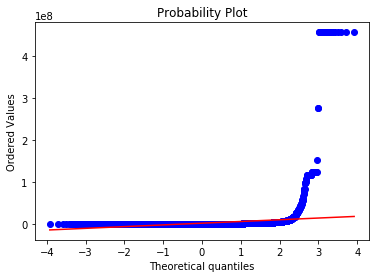

In [66]:
fig = plt.figure()
res = stats.probplot(data_df["info_sold_price"], plot=plt)
plt.show()

In [11]:
property_id = set(data_df["info_property_id"].unique())
len(property_id)

15755

In [12]:
import json

details = {}
full_data = "data/Orange-County/full-orange-county.json"

with open(full_data) as fIn:
    for line in fIn:
        row = json.loads(line)
        
        # Lấy phần info
        info = row.get("info")
        # ID.
        info_property_id = info.get("property_id")
        
        if int(info_property_id) in property_id:
            # Detail
            detail = row.get("details")
            details[int(info_property_id)] = detail

In [29]:
#details[1099038732]
details[1099497504]

['<div about="#400welectricave" class="detail-text" style="overflow:inherit" typeof="Place" vocab="http://schema.org/"> <p><span property="name">400 W Electric Ave</span> is a condominium located in <span property="address" resource="#400welectricave-address" typeof="PostalAddress"> <span property="addressLocality">La Habra</span>, <span property="addressRegion">CA</span> <span property="postalCode">90631</span></span>. Built in 1991, this property features <span property="additionalProperty" resource="#400welectricave-beds" typeof="PropertyValue"><meta content="Bedrooms" property="name"/><meta content="2" property="value"/>2 bedrooms</span>, <span property="additionalProperty" resource="#400welectricave-baths" typeof="PropertyValue"><meta content="Bathrooms" property="name"/><meta content="3" property="value"/>3 bathrooms</span> and <span property="additionalProperty" resource="#400welectricave-living" typeof="PropertyValue"><meta content="Living Space" property="name"/><meta content=

In [22]:
data_df["info_property_id"]

0        1102337060
1        1102351069
2        1102336622
3        1102354775
4        1102343308
5        1102353937
6        1102338857
7        1102360374
8        1102347550
9        1102352210
10       1102352173
11       1102348813
12       1102340032
13       1102342166
14       1102342539
15       1102337958
16       1102347279
17       1102346811
18       1102348708
19       1102305363
20       1102339280
21       1102339830
22       1102287017
23       1102288803
24       1102290714
25       1102337059
26       1102340285
27       1102283658
28       1102360864
29       1102306310
            ...    
15725    1096668420
15726    1096655854
15727    1096665364
15728    1096660775
15729    1096660509
15730    1096660456
15731    1096667985
15732    1096663268
15733    1096558405
15734    1096668120
15735    1096667941
15736    1096660627
15737    1096653331
15738    1096668761
15739    1096842107
15740    1096676463
15741    1096676118
15742    1096673666
15743    1096717892


In [27]:
data_df[data_df.info_property_id == 1102351069].info_size

1    1503.0
Name: info_size, dtype: float64

In [26]:
data_df[data_df.info_property_id == 1102351069].info_lot_size

1    3478.0
Name: info_lot_size, dtype: float64

In [20]:
nan_lot_size_df[nan_lot_size_df.info_property_id == 1099038732].info_size

9484    1168.0
Name: info_size, dtype: float64

In [5]:
# Phần dữ liệu có lot_size là null
nan_lot_size_df = data_df[pd.isna(data_df["info_lot_size"])]

In [6]:
len(nan_lot_size_df)

5116

In [7]:
set(nan_lot_size_df["info_property_id"])

{1098186757,
 1101889542,
 1101430790,
 1099038732,
 1102151695,
 1099956239,
 1101430803,
 1097334803,
 1099497504,
 1101561893,
 1100742701,
 1101922352,
 1097760816,
 1097760823,
 1102184505,
 1101627460,
 1097433164,
 1100382286,
 1101037654,
 1101430888,
 1102282864,
 1102184561,
 1097138288,
 1100087412,
 1099169912,
 1101758592,
 1101234327,
 1101332647,
 1099759785,
 1100578992,
 1099890875,
 1101889724,
 1099661501,
 1101725886,
 1099071682,
 1102119111,
 1099235575,
 1101562104,
 1102151933,
 1097597182,
 1100087555,
 1099628804,
 1098121477,
 1097761029,
 1099497743,
 1102217489,
 1098613023,
 1101627682,
 1097662768,
 1100185912,
 1098187069,
 1099170115,
 1099170118,
 1099170119,
 1101365591,
 1101562203,
 1101365601,
 1097924961,
 1097105768,
 1100579189,
 1099170199,
 1099891109,
 1101136294,
 1096843692,
 1101365688,
 1100349883,
 1099891131,
 1098318267,
 1100218815,
 1097204160,
 1102152141,
 1097138644,
 1097335262,
 1099235809,
 1099137519,
 1102119431,
 1101365776,

### Xem phần street

In [30]:
tmp = data_df.address_street.str.replace(r'[^a-zA-Z ]', '').str.strip()

In [31]:
tmp

0                    Silver Crk
1                         Alava
2                     Hansen Ln
3                       Copante
4                    Burwood St
5                   Overhill Dr
6                    Wild Horse
7                Valley View St
8                  La Jolla Plz
9                   Jaripol Cir
10                  Santa Nella
11                  Yosemite Ct
12                     David Dr
13                   Sandcastle
14                 W Cherry Ave
15                   Arizona St
16                 E Via Fresco
17                  Avocado Cir
18                    La Pat Pl
19          Silverado Canyon Rd
20                Fairlynn Blvd
21                    Player Ln
22                    Farmer Ln
23                  E Quartz Ln
24                Chantilly Cir
25                      Chandon
26                     Cardinal
27                     Taft Way
28                  Saverne Cir
29                     Brush Dr
                  ...          
15725   

In [32]:
len(tmp.unique())

9663

In [33]:
df  = data_df[pd.isna(data_df.address_street)]
len(df)

46

In [46]:
value_tmp = tmp.value_counts()

In [50]:
#value_tmp["Silver Crk"]
n = 0
for value in value_tmp:
    if value == 1:
        n += 1
n

6528

### Xem phần locality

In [51]:
list_locality = data_df.address_locality.unique()
print(list_locality)
print(len(list_locality))

['Irvine' 'Mission Viejo' 'Huntington Beach' 'La Habra' 'Santa Ana'
 'Buena Park' 'Garden Grove' 'Rancho Mission Viejo'
 'Rancho Santa Margarita' 'Fountain Valley' 'Newport Beach' 'Aliso Viejo'
 'Fullerton' 'Westminster' 'Anaheim' 'Yorba Linda' 'Silverado' 'Tustin'
 'Placentia' 'Newport Coast' 'Costa Mesa' 'San Clemente' 'Los Alamitos'
 'Laguna Niguel' 'Cypress' 'Seal Beach' 'San Juan Capistrano' 'Orange'
 'Laguna Woods' 'Coto De Caza' 'Laguna Hills' 'Brea' 'Foothill Ranch'
 'Midway City' 'Dana Point' 'Stanton' 'Lake Forest' 'Ladera Ranch'
 'La Habra Heights' 'La Palma' 'Laguna Beach' 'El Toro' 'Capistrano Beach'
 'Villa Park' 'Rossmoor' 'Trabuco Canyon' 'Fountain Vly' 'Portola Hills'
 'Rcho Sta Marg' 'Monarch Beach' 'Corona Del Mar' 'Dove Canyon' nan
 'Corona Dl Mar' 'Sunset Beach']
55


In [53]:
data_df.address_locality.value_counts()

Irvine                    1407
Anaheim                   1281
Huntington Beach          1056
Santa Ana                  912
Mission Viejo              774
Fullerton                  694
Orange                     687
Garden Grove               578
Yorba Linda                513
San Clemente               510
Laguna Niguel              492
Newport Beach              491
Costa Mesa                 481
Tustin                     414
Lake Forest                375
Rancho Santa Margarita     371
Aliso Viejo                322
Buena Park                 321
La Habra                   300
Dana Point                 268
Brea                       254
Laguna Hills               242
Placentia                  237
Westminster                236
Fountain Valley            223
Laguna Beach               219
San Juan Capistrano        215
Laguna Woods               208
Cypress                    202
Rancho Mission Viejo       170
Trabuco Canyon             150
Ladera Ranch               132
Los Alam

### Xem phần region

In [54]:
list_region = data_df.address_region.unique()
print(list_region)
print(len(list_region))

['CA' 'NV']
2


In [55]:
data_df.address_region.value_counts()

CA    15753
NV        2
Name: address_region, dtype: int64

### Xem phần address code

In [56]:
list_address_code = data_df.address_code.unique()
print(list_address_code)
print(len(list_address_code))

[92603 92692 92646 90631 92705 92602 90620 92844 92694 92688 92708 92663
 92656 92833 92683 92807 92886 92676 92782 92870 92657 92618 92626 92604
 92647 92780 92673 90621 90720 92677 92801 92808 92612 92648 92620 90740
 92614 92701 92675 92835 92691 92649 92869 92637 92679 92704 92653 92843
 92802 92805 92823 92610 92655 92865 92629 92868 92703 92706 90680 92660
 92804 92831 92627 92707 92662 92840 92887 92866 92630 92624 92867 92672
 90623 90630 92651 92841 92661 92606 92821 92845 92806 92861 92832 92625
 92617 90742 92685]
87


In [57]:
data_df.address_code.value_counts()

92677    499
92694    427
92630    412
92688    376
92656    367
92618    367
92886    357
90631    353
92646    338
92692    333
92691    316
92620    309
92679    284
92627    279
92833    274
92660    266
92672    262
92649    255
92780    252
92705    250
92648    248
92673    248
92804    248
92805    247
92807    241
92629    240
92870    237
92683    235
92821    224
92708    224
        ... 
92610    117
92806    115
92604    114
90621    111
92706    109
92625    109
92603    107
92841    106
92843    100
90680     99
92703     99
92845     95
92832     95
92844     89
92657     86
90740     83
92868     76
92606     71
92866     65
92624     61
90623     55
92661     35
92676     35
92861     33
92823     30
92662     27
92655     17
92617     12
90742      8
92685      1
Name: address_code, Length: 87, dtype: int64

### Xem phần type của căn nhà

In [58]:
list_type = data_df.info_type.unique()
print(list_type)
print(len(list_type))

['Condominium' 'Single Family Residence' 'Multi-Family Dwellings'
 'MISCELLANEOUS' 'Contact Agent' 'Cooperative'
 'Miscellaneous Structures - Ranch, Farm Fixtures'
 'Governmental / Public Use (general)' 'Commercial - Vacant Land'
 'Miscellaneous (Residential)' 'Duplex (2 units, any combination)'
 'Residential - Vacant Land' 'Agricultural (unimproved) - Vacant Land'
 'Miscellaneous (general)']
14


In [59]:
data_df.info_type.value_counts()

Single Family Residence                            10248
Condominium                                         4316
MISCELLANEOUS                                        585
Multi-Family Dwellings                               404
Contact Agent                                        151
Miscellaneous Structures - Ranch, Farm Fixtures       12
Cooperative                                           11
Governmental / Public Use (general)                    8
Residential - Vacant Land                              6
Miscellaneous (Residential)                            6
Miscellaneous (general)                                4
Duplex (2 units, any combination)                      2
Agricultural (unimproved) - Vacant Land                1
Commercial - Vacant Land                               1
Name: info_type, dtype: int64

### Xem phần year built 

In [ ]:
list_year_built = data_df.info_year_built.unique()
print(list_year_built)
print(len(list_year_built))

### Xử lý cột taxes_taxes

In [ ]:
tmp = data_df.taxes_taxes.str.partition(' ')

In [ ]:
# Xem phần tiền
tmp[0]

In [ ]:
# Xem phần phần % thuế
tmp[2].str.replace("(","").str.replace(")","") # ảo 2 chỗ ".str" -> why?

### Xem thử xem các id căn nhà có độc lập không

In [ ]:
len(data_df.info_property_id.unique()) # bằng 16011 thì ngon lành!